# Intermediate Machine Learning
# 中级机器学习
处理丢失值（missing values）、非数值类型值（non-numberic values）、数据泄漏（data leakage）等等。可以使模型更加精确。内容明细如下：

1、应对现实中数据集的（**missing values、categorical variables**）数据类型

2、设计**pipelines**来提升机器学习代码的质量

3、使用先进的模型验证技术（**cross-validation**)

4、构建经常赢得Kaggle竞赛的最先进的（state-of-the-art）模型（**XGBoost**）

5、避免常见和重要的数据科学失误（**leakage**)

# 1、dealing with missing values
存在丢失值的原因很多，比如：

1、二室房屋没有第三个房间的数据

2、被调查这回避一些隐私问题

许多机器学习库（包括scikit-learn）在使用有丢失值的数据拟合模型时会报错。所以要对丢失值进行处理。处理方式有三种：

1）最简单的：删除有丢失值的列

除非删除的列中大部分的值是丢失的，不然，这种方法将会使模型丢失大量的信息（可能是潜在的有用信息）。

2）较好的选项：修补（Imputation）

Imputation用一些数值填补丢失的值，比如，填入每列的平均值。大多数情况下，填入的值不精确，但是通常填补丢失值会比删除整列获得更加精确的模型。

3）修补的扩展（An Extension To Imputation）

修补的数据可能会系统性地比真实值或大或小，有丢失值的数据也可能在某些方面比较特殊。因此，如果模型综合考虑了哪些行有丢失数据将会表现更好。在修复扩展这个方法中，填补丢失值的同时，增加一列记录修补条目的位置。有时，这种方法能获得更好的结果，有时也会没有改善。

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('./melbourne-housing-snapshot/melb_data.csv')

# 目标
y = data.Price

melb_predictors  = data.drop(['Price'], axis=1)

# 选取所有的数值指标作为预测因子（predictors）
X = melb_predictors.select_dtypes(exclude=['object'])

# 训练数据和验证数据划分
X_train,X_valid,y_train,y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 计算不同数据修复方式的随机森林模型mae校验结果
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [4]:
# 使用删除存在丢失值列的方式处理丢失数据，并计算模型预测mae

# 获取有丢失值的列
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# 从训练数据和测试数据中删除含有丢失值的列
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
183550.22137772635


使用**SimpleImputer**用每列的平均值替换每列的丢失值。

尽管简单，使用平均值进行填补效果通常很好（但是因数据集不同而异）。虽然统计者使用过更复杂的填补方式（比如**regression imputation**），但是，这些复杂的方式在机器学习模型中使用后，一般也不会导致额外的效果提升。

但是，通过下面代码，可以很明显看出**修补丢失值**比删除有丢失值的列要好。

In [5]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer()

imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation会将数据集的列名移除，要补充列名
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE form Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE form Approach 2 (Imputation):
178166.46269899711


In [6]:
# Imputation的扩展：添加一列标记有丢失数据的数据行

# 复制数据集，避免修补时改变原始数据
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# 添加新列标记要修补丢失值的行
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# 修补会删除列名，回补列名
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
178927.503183954


In [7]:
# 训练数据的形状
print(X_train.shape)

# 训练数据中每列丢失值的数量
missing_val_count_by_column = (X_train.isnull().sum())
# 有丢失值的列，及丢失值的数量
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(10864, 12)
Car               49
BuildingArea    5156
YearBuilt       4307
dtype: int64


从上面的代码可以看出，训练数据有10864行，12列，三列有丢失数据。对于丢失的列，有两列丢失了将近二分之一的数据。因此，删除这两列会丢失很多有用的信息，所以**此时**修补数据比删除数据效果好。

但是，对于下面的代码，结果就不同了：

In [10]:
X_full = pd.read_csv('./melbourne-housing-snapshot/train.csv', index_col='Id')

# 删除目标中有丢失数据的行
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
# 分离目标和预测因子
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# 仅使用数值类型的预测因子
X = X_full.select_dtypes(exclude=['object'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
619,20,90.0,11694,9,5,2007,2007,452.0,48,0,1774,1822,1828,0,0,1828,0,0,2,0,3,1,9,1,2007.0,3,774,0,108,0,0,260,0,0,7,2007
871,20,60.0,6600,5,5,1962,1962,0.0,0,0,894,894,894,0,0,894,0,0,1,0,2,1,5,0,1962.0,1,308,0,0,0,0,0,0,0,8,2009
93,30,80.0,13360,5,7,1921,2006,0.0,713,0,163,876,964,0,0,964,1,0,1,0,2,1,5,0,1921.0,2,432,0,0,44,0,0,0,0,8,2009
818,20,NaN,13265,8,5,2002,2002,148.0,1218,0,350,1568,1689,0,0,1689,1,0,2,0,3,1,7,2,2002.0,3,857,150,59,0,0,0,0,0,7,2008
303,20,118.0,13704,7,5,2001,2002,150.0,0,0,1541,1541,1541,0,0,1541,0,0,2,0,3,1,6,1,2001.0,3,843,468,81,0,0,0,0,0,1,2006


In [11]:
# 查看训练数据的概况
print(X_train.shape)

missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1168, 36)
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [12]:
# 删除丢失数据列
cols_with_missings = [col for col in X_train.columns
                     if X_train[col].isnull().any()]
reduced_X_train = X_train.drop(cols_with_missings, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missings, axis=1)
print("MAE (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

# 修补丢失数据
imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(imputer.transform(X_valid))
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE (Drop columns with missing values):
18866.728767123288
MAE (Imputation):
19255.558333333334


这个例子中，**删除丢失数据列表现竟然更好**。

可能的原因是数据中的干扰数据，应一个潜在的原因是Imputaion的方式对这个数据集并不合适。也许使用0来替换丢失值（或者用使用频率较高的值，再或者使用其它的方式）比使用平均值替换丢失值更好。比如，对于`GarageYrBlt`这列（表示车库的建造年份），没有值，可能是因为这条记录中的房产没有车库，这时填补平均值显然不妥；那么用最小值填补缺失值呢？这种情况下，哪种修补方式更好并不清晰；但是，也许我们可以直接排除某些方式——比如用0来填补丢失值会导致可怕的偏差。

# 类别变量（categorical variables）处理

类别变量（categorical variables，分类变量）只有有限个数量的值

1、比如，调查吃早餐频率时的有限个选项："Never", "Rarely", "Most days", 或者"Every day"。此时，这个数据就是分类的（categorical），因为它的值只有有限的几个类别。

2、人们拥有的车的品牌也是分类的，比如， "Honda", "Toyota", 和 "Ford"。

在Python的大多数机器学习模型中未经处理的使用这些值都会导致错误。有三种类别变量的处理方式：

1）删除类别变量

最简单，但是，仅适用于类别变量锁对应的列没有有用信息的场合。

2）**Label Encoding**

为每个唯一的类别值分配一个不同的整数。这种方法假设一个类别的顺序，比如："Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3)；这种假设在这个例子中是可行的，因为，这个类别的排序是无争议的。但是，并不是所有的类别变量在取值上有清晰的排序，这种方式将类别变量转换成了**有序变量（ordinal variables）**。对于基于树的模型（比如决策树和随机森林），使用有序变量的Label encoding运行良好。

3）**One-Hot Encoding**

One-hot编码会创建新的列来表示源数据中存在的（或者缺少的）任意可能值。

*举个例子*：“Color”是一个类别变量，有三个值：“Red”，“Yellow”，“Green”。与之对应的one-hot编码对于任意可能的值都有一个对应的列，并且有一行值对应源数据集中的每一行。如果源数据值是“Red”，“Red”列对应的行值就是1；如果源数据是“Yellow”，那么“Yellow”列对应的行的值就是1，以此类推。

与Label编码不同，one-hot编码不会假设一个类别的顺序。因此，如果类别变量没有明确的顺序（例如，颜色就没有大小顺序）可以使用这种处理方式。对于本身没有顺序的类别变量称为**标称变量（nominal variable）**。

One-hot对于**类别数量比较大**的类别变量**通常性能不佳**（比如类别值超过15种）。

对于较大的数据集，one-hot编码会极大地扩展数据集的大小。因此，一般只对低基数（cardinality）的列使用one-hot编码。对于高基数的列，可以删除或者使用label编码。

In [17]:
data = pd.read_csv('./melbourne-housing-snapshot/melb_data.csv')

# 获取目标和特征
y = data.Price
X = data.drop(['Price'], axis=1)

# 分割训练数据和测试数据
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# 删除有丢失值的列
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# 筛选低基数（Cardinality，一列中唯一值的个数）列
low_cardinality_cols = [cname for cname in X_train_full.columns
                       if X_train_full[cname].nunique() < 10 and X_train_full[cname].dtype == 'object']

# 筛选数值类型（'int64', 'float64'）的列的列名
numerical_cols = [cname for cname in X_train_full.columns
                 if X_train_full[cname].dtype in ['int64', 'float64']]
# numerical_cols = X_train_full.select_dtypes(exclude=['object'])，与上面代码的不同是，返回的是数据集，不只是列名

# 要选择的列
my_cols = low_cardinality_cols + numerical_cols

X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

X_train.head()

c:\program files\python\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


In [23]:
X_train.dtypes

Type              object
Method            object
Regionname        object
Rooms              int64
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Landsize         float64
Lattitude        float64
Longtitude       float64
Propertycount    float64
dtype: object

In [22]:
s = X_train.dtypes == 'object'
# 类别变量列
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Type', 'Method', 'Regionname']


In [ ]:
# 计算mae的函数
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [24]:
# 第一种方法，删除类别变量列
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
183550.22137772635


In [26]:
# 第二种方法，Label Encoding
# 使用scikit-learn的`LabelEncoder`类来进行标签编码。要对类别变量列分别进行标签编码。
from sklearn.preprocessing import LabelEncoder

label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

label_encoder = LabelEncoder()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])
    
print("MAE from Approach 2 (Label Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Label Encoding):
175062.2967599411


上面的代码中，对于每一列，随机地给每个唯一值分配了一个不同的整数。这是一种比提供自定义标签更简单的常用方式；但是如果为所有的有序变量提供有依据的标签将会获得额外的巨大的性能提升。

使用训练数据拟合label encoder时，label encoder会**为训练数据中出现的所有唯一值分配一个对应的整数值标签**。如果测试数据中有训练数据中没有的值，encoder没有标签能够对这些值进行分配，会抛出错误。解决方法包括：为训练数据中没有的类别值写一个自定义的label encoder，和最简单的——删除引起问题的类别列。

In [27]:
# 第三者方法，One-hot encoding
''' 使用scikit-learn的OneHotEncoder进行one-hot encoding。有许多可以个性化OneHotEncoder的参数
设置`handle_unknown='ignore'`来避免当测试数据中有训练数据中没有的类别是报错
设置`sparse=False`来确保编码的列返回为一个numpy数组（而不是稀疏矩阵）

使用这个编码器，只用提供想要进行one-hot编码的类别变量列。
'''
from sklearn.preprocessing import OneHotEncoder

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding移除了索引，补充索引
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# 移除类别列（用one-hot encoding替换）
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# 把one-hot编码后的列补充到数值特征df
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)


print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
176703.63810751104


从上面的例子，可以看出删除类别列性能最差，Label encoding和One-hot encoding的差别不大，不能明确的说一个比另一个好。
通常，one-hot encoding一般最好，删除类别变量列最差，但是因实际情况而异。

# Pipeline
**Pipelines**组织数据预处理和模型拟合代码的简单方式。pipeline将预处理步骤和模型拟合步骤绑定在一起，可以将这两个步骤当作一个步骤使用。

pipeline的好处：

1、更加清晰的代码：数据预处理的每个步骤可能是非常杂乱的。使用pipeline，就不必人工地在每一步跟踪训练和验证数据。

2、Bugs更少：缺少步骤或者忘记预处理步骤的可能性更小。

3、更容易产品化（Productionize）：

4、有更多的模型验证选项

In [28]:
data = pd.read_csv('./melbourne-housing-snapshot/melb_data.csv')
y = data.Price
X = data.drop(['Price'], axis=1)

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

categorical_cols = [cname for cname in X_train_full.columns
                    if X_train_full[cname].nunique() < 10 and X_train_full[cname].dtype == "object"]

numerical_cols = [cname for cname in X_train_full.columns
                  if X_train_full[cname].dtype in ['int64', 'float64']]

my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,1.0,0.0,NaN,1940.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,1.0,193.0,NaN,NaN,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,1.0,555.0,NaN,NaN,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,1.0,265.0,NaN,1995.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,2.0,673.0,673.0,1970.0,-37.76230,144.8272,4217.0


In [29]:
# 要使用pipeline对X_trian进行缺失值处理、类别变量编码

'''
Step 1. 定义预处理步骤
使用`ColumnTransformer`类来绑定不同的预处理步骤：
1、补充数值类型数据的缺失值
2、补充类别数据的缺失值并应用one-hot编码
'''

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# 数值类型数据的预处理
numerical_transformer = SimpleImputer(strategy='constant')

# 类别数据的预处理
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 将两个预处理步骤绑定
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

'''
Step 2. 定义模型
'''
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

'''
Step 3. 创建并评估Pipeline
使用`Pipeline`类来定义绑定数据预处理和模型拟合步骤的pipeline。需要注意：
1、使用pipeline，很简洁的就能进行训练数据预处理和模型拟合。
2、使用pipeline,把未进行特征预处理的X_valid特征数据放进`predict()`函数，pipeline会自动进行特征预处理，然后进行预测。
'''
from sklearn.metrics import mean_absolute_error

my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

my_pipeline.fit(X_train, y_train)

preds = my_pipeline.predict(X_valid)

score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 160679.18917034855


Pipeline在整理机器学习代码、避免错误方面很有价值，对于有复杂数据预处理的工作流尤其有用。

# Cross-validation（交叉验证）
Cross-validation是一种评估模型性能的更好方法。

机器学习是一个迭代的过程。要面临预测变量的选择、模型种类选择、模型参数选择等等问题。之前的例子中，使用的是用验证数据（测试数据）检测模型质量这种数据驱动的方式。但是，这种方式有些缺点，假如有一个5000行数据的数据集，一般把20%的数据作为测试数据。但是，这会使模型检测结果受某些随机因素的影响。即，一个模型可能在这1000行数据上表现良好，而在不同的1000行数据上不精确。极端情况下，测试数据只有1条，这时用它来检测不同模型，检测结果显然不可靠。

通常测试数据越多，模型验证随机性干扰越小，验证结果越可靠。不幸的是，只能测试数据越多训练数据就越少，越少训练数据，模型也就越差。

交叉验证中，在特征数据的不同子集上运行模型拟合过程，以多方面验证模型质量。比如，首先把数据分为5块，即所谓的把数据分为5个“folds”。然后对每一个fold进行实验：

1、Experiment 1，把第一个fold的数据作为测试数据，其它数据作为训练数据。用第一个fold能得到一个模型质量评估结果。

2、Experiment 2，把第二个fold的数据作为测试数据，其它数据作为训练数据。用第二个fold又能得到一个模型质量评估结果。

3、以此类推。最后，全部的数据都用来进行了测试和训练。并得到了一个基于所有数据的模型验证结果。

交叉验证是一种更加精确的模型验证方法，但是运行耗时长，因为它评估了多个模型。所以要作一些权衡：

1）对于小数据集，运算开销比较小，可以进行交叉验证。

2）对于大数据集，仅用一次验证很高效。并且可能有足够的数据来进行数据测试，就没必要用交叉验证来反复进行模型拟合和评估。

并没有一个简单的阈值来区分上面所说的大、小数据集。可以根据模型拟合需要的时间来自己权衡；或者，可以运行交叉验证并查看每次experiment的结果是否接近，如果每次的experiment结果相近，那么一次验证可能是更高效的。

In [30]:
data = pd.read_csv('./melbourne-housing-snapshot/melb_data.csv')
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]
y = data.Price

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
'''
尽管可以不使用pipelines来进行交叉验证，但是那是相当困难的。
'''
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])
# 使用scikit-learn的`cross_val_score()`来获取交叉验证的得分。参数`cv`表示folds的数量
from sklearn.model_selection import cross_val_score

# 计算的是`负`MAE，所以乘以`-1`
scores = -1 * cross_val_score(my_pipeline, X, y, cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

print("Average MAE score (across experiments):")
print(scores.mean())

MAE scores:
 [301628.7893587  303164.4782723  287298.331666   236061.84754543
 260383.45111427]
Average MAE score (across experiments):
277707.3795913405


In [44]:
def get_score(n_estimators):
    my_pipeline = Pipeline(steps=[
        ('preprocessor', SimpleImputer(strategy='median')),
        ('model', RandomForestRegressor(n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X, y, cv=6,scoring='neg_mean_absolute_error')
    return scores.mean()

{50: 276173.53505106276, 100: 275170.67055667593, 150: 274891.4527814189, 200: 274599.9014491626, 250: 274560.07576938247, 300: 274563.56272219523, 350: 274408.3083048097, 400: 274470.12243433174}


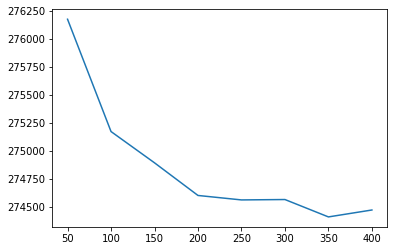

In [45]:
dlist = list(range(50, 450, 50))
scores = [get_score(x) for x in dlist]
results = dict(zip(dlist, scores))
print(results)

from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

上面是寻找随机森林模型参数`n_estimators`最佳值的例子。**网格搜索（grid search）**是一个确定机器学习模型**最佳组合(combination)参数**的简便方法。scikit-learn也包含了一个内置函数`GridSearchCV()`可以用来高效进行网格搜索。

# XGBoost
随机森林算法，通过将许多决策树算法预测结果进行平均获得了比单一决策树更好的效果。

随机森林算法是一个“ensemble method”（整合方法）。按照定义，**ensemble methods**综合了几个模型的预测结果。

**Gradient Boosting**也是一个ensemble method，通过循环迭代地往ensemble中添加模型。

首先用一个模型初始化这个ensemble，这个模型的预测结果是非常初级的（即使它的预测结果很不精准，后续添加到ensemble中的模型会定位这些错误）。然后，开启循环：

首先，用当前ensemble为数据集中的每个记录生成预测结果。为了进行预测，将从ensemble中的所有模型添加这些预测。这些预测被用来计算丢失函数（loss function）比如mean square error。然后，使用丢失函数拟合一个新的模型添加到这个ensemble中。具体来说，要确定模型的参数以便添加这个新的模型后能够减少丢失（reduce the loss）。（注，“gradient boosting”中的“gradient”指的是在丢失函数上使用“gradient descent”来确定新模型的参数。）。最后将这个新模型添加到ensemble中，并重复以上过程。

**XGBoost**即extream gradient boosting，是gradient boosting的一种实现，它有一些聚焦在性能和速度上的额外的特征。使用前需要安装xgboost。（scikit-learn有另一个版本的gradient boosting，但是XGBoost有一些技术上的优势。）

In [47]:
data = pd.read_csv('./melbourne-housing-snapshot/melb_data.csv')

cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

y = data.Price

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

from xgboost import XGBRegressor
my_model = XGBRegressor()
my_model.fit(X_train, y_train)

predictions = my_model.predict(X_valid)
print("MAE:" + str(mean_absolute_error(predictions, y_valid)))

MAE:237601.92817562592


XGBoost有些参数会极大地影响精度和训练速度，比如：

`n_estimators`

它指定模型拟合循环的次数；它与ensemble中包含的模型个数相同，太小会引起欠拟合，太大会导致过拟合；通常的取值范围是100~1000，但是这很大程度上依赖于`learning_rate`参数。

`early_stopping_rounds`

它提供一种自动找到理想的`n_estimators`的方法。Early stopping会引起在验证得分（validation score）不再提升时，停止模型的迭代，即使没有达到`n_estimators`上限。把`n_estimators`设置为一个较大的值，并使用`early_stopping_rounds`来找到停止迭代的最佳时间，是一个不错的做法。由于，存在随机的概率可能会导致某个循环中验证得分没有提升，因此，需要指定一个停止模型迭代前至少循环的次数。把`early_stopping_rounds`设置为5是一个合理的选择。使用`early_stopping_rounds`时，还需要设置一些用来计算验证得分的数据——使用`eval_set`参数来设置。

`learning_rate`

除了通过将每个组件模型的预测结果简单累加来获取预测结果外，还可以在累加之前用一个很小的数值（即**learning rate**）去乘以每个模型的预测结果。这意味着每个加入到ensemble中的模型树对结果的影响更少。因此，可以设置较大的而不导致过拟合。如果设置了`early_stopping_rounds`，合适的树的数量会自动的确定。通常，较小的learning rate和较大的estimators数量会使XGBoost模型更加精确，但是由于迭代次数更多模型训练会耗时更长。默认的`learning_rate`为0.1。

`n_jobs`

对于大型的数据集需要考虑运行的时间，可以通过并行处理使模型更快。通常把`n_jobs`设置为与机器的核心数量相同。对于较小的数据集，这个参数没有影响。这个参数不会影响模型的精确性，只对于大型数据集来说有必要。

In [48]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

predictions = my_model.predict(X_valid)
print("MAE:" + str(mean_absolute_error(predictions, y_valid)))

MAE:234299.59193667158


In [60]:
X = pd.read_csv('./melbourne-housing-snapshot/train.csv', index_col='Id')
X_test_full = pd.read_csv('./melbourne-housing-snapshot/test.csv', index_col='Id')
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [61]:
X_test_full.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [62]:
# 删除有缺失值的行
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
# 删除SalePrice列
X.drop(['SalePrice'], axis=1, inplace=True)

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

low_cardinality_cols = [cname for cname in X_train_full.columns
                        if X_train_full[cname].nunique() < 10 and X_train_full[cname].dtype == "object"]
numeric_cols = [cname for cname in X_train_full.columns
                if X_train_full[cname].dtype in ['int64', 'float64']]

my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# 使用pandas进行one-hot编码
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)

In [63]:
X_train.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=227)

In [64]:
X_valid.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLI', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=208)

In [65]:
# 与X_train的列对齐
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [66]:
X_valid.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=227)

# Data leakage
**Data leakage**或者leakage，当训练数据集中有与目标有关的信息，但是当把模型用来进行预测时，这些相关的数据不可用，就会发生leakage。这会导致在训练数据上（或者测试数据上）表现很好，而在生产中表现很差。泄漏有两种：**目标泄漏(target leakage)**和**训练-测试混杂(train-test contaminnation)**。

**Traget leakage**

当进行预测的时候，预测因子中包含了不可用的数据的时候会发生目标泄漏。不仅要考虑特征是否对进行预测有用，从数据变得可用的时间或者时序（timing or chronological order that data become avaliable）方面考虑目标泄漏的问题也很重要。比如，在肺炎诊断中，数据包含“得了肺炎”、“年龄”、“体重”、“性别”、“进行肺炎治疗”等指标，但是目标列“得了肺炎”和“进行肺炎治疗”高度相关，这就是目标泄漏。如果模型注意到“进行肺炎治疗”和“得了肺炎”高度相关，那么就高度依赖“进行肺炎治疗”这个指标进行预测，而实际预测时“进行肺炎治疗”这个指标肯定是没有的，模型预测肯定也是相当不准确的。为了防止目标泄漏，任何目标值确定了之后会引起变化的指标（列）都应该被排除在特征之外。

另外，如果时间是一个特征，要对未来进行预测，那么训练数据时间必须都在验证数据之前，以防止目标泄漏。pandas的`df.sort_values('col_time')`可以按时间升序排序DataFrame。

**Train-Test contamination**

模型验证意味着检验模型在对模型没有遇到过的数据进行预测时的性能。但是，如果验证数据影响了模型的拟合过程，那么会影响模型验证这一过程，影响对模型的评估。当进行更加复杂的特征工程时，这个问题就更加微妙（并且更加危险）。所以，需要仔细的区分验证数据和训练数据。如果验证数据是通过简单地train-test切分得到的，那么，在任何拟合过程中都要排除掉验证数据（包括模型拟合和数据预处理中的拟合）。如果使用pipeline，这就比较简单了。使用交叉验证时，在pipeline中进行预处理就更加关键。

In [49]:
data = pd.read_csv('./aer-credit-card-data/AER_credit_card_data.csv',true_values=['yes'],false_values=['no'])
y = data.card
X = data.drop(['card'], axis=1)
print("Number of rows in the dataset:", X.shape[0])
X.head()

Number of rows in the dataset: 1319


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5


In [50]:
# 使用交叉验证
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

my_pipeline_1 = make_pipeline(RandomForestClassifier(n_estimators=100))
cv_scores = cross_val_score(my_pipeline_1, X, y, cv=5, scoring='accuracy')

print("Cross-validation accuracy: %f" % cv_scores.mean())

Cross-validation accuracy: 0.980283


结果模型精度高达——98%！从经验来说，几乎不可能。很有可能是发生了目标泄漏。所以要从数据入手排查，列描述如下：

card: 1 if credit card application accepted, 0 if not

reports: Number of major derogatory reports

age: Age n years plus twelfths of a year

income: Yearly income (divided by 10,000)

share: Ratio of monthly credit card expenditure to yearly income

expenditure: Average monthly credit card expenditure

owner: 1 if owns home, 0 if rents

selfempl: 1 if self-employed, 0 if not

dependents: 1 + number of dependents

months: Months living at current address

majorcards: Number of major credit cards held

active: Number of active credit accounts

有几个指标比较可疑，比如expenditure，并没有明确说明是这张卡的expenditure还是这个用户所有卡的expenditure，那么要进行一些数据比较来确认。

In [52]:
# 有卡者开支
expenditures_cardholders = X.expenditure[y]
# 无卡者开支
expenditures_noncardholders = X.expenditure[~y]

print('Fraction of those who did not receive a card and had no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean()))
print('Fraction of those who received a card and had no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))

Fraction of those who did not receive a card and had no expenditures: 1.00
Fraction of those who received a card and had no expenditures: 0.02


In [57]:
# 删除有目标泄漏风险的列
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)

cv_scores = cross_val_score(my_pipeline_1, X2, y, cv=5,scoring='accuracy')

print("Cross-val accuracy: %f" % cv_scores.mean())

Cross-val accuracy: 0.831688


这个准确性要低得多，这可能令人失望。 但是，我们可以期望在用于新应用程序时它的正确率大约为80％，而泄漏模型可能会比这严重得多（尽管其交叉验证的表观得分更高）。

In [3]:
# 一个sklearn ml的例子：红酒质量预测——Red Wine Snob Edition
# from site:https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib

# 红酒质量数据，目标quality，指标都是数值，不含na，‘;’分隔的csv
wine_raw_ds_url = './datasets/wine-quality/winequality-red.csv'
data = pd.read_csv(wine_raw_ds_url, ';')
# 查看数据集概况
print(data.head())
print(data.shape)
print(data.describe())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [5]:
# 分割数据
y = data.quality
X = data.drop('quality', axis=1)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2,
                                                 random_state=123, stratify=y)

*train_test_split*函数的`stratify`参数为**‘分层’**：

在实践中，按照目标对样本进行分层是一个好的习惯。能够确保训练数据与测试数据类似，从而使模型评估结果更可靠。

**标准化（Standardization）**：

减去每个特征的平均值，然后除以特征的标准差的过程。

（Standardization is the process of subtracting the means from each feature and then dividing by the feature standard deviations.）

标准化是机器学习的一个常见需求。许多算法都假设所有的特征都是以0为中心的，并且方差（variance，方差、变化幅度）几乎是一样的。

In [9]:
# sklearn可以很方便的对数据集进行缩放
X_train_scaled = preprocessing.scale(X_train)
print(X_train_scaled[:5])

# 计算缩放后的平均值
print(X_train_scaled.mean(axis=0))
# 计算缩放后的标准差
print(X_train_scaled.std(axis=0))

[[ 0.51358886  2.19680282 -0.164433    0.03639439 -0.01061089 -0.37524823
   1.42078387  1.62802923  1.08415147 -0.69866131 -0.58608178]
 [-1.73698885 -0.31792985 -0.82867679 -0.24254751 -0.81867452  0.0029943
   1.29823518 -2.62843695  1.46964764  1.2491516   2.97009781]
 [-0.35201795  0.46443143 -0.47100705 -0.10307656 -0.09348921 -0.94261202
  -0.81572967 -0.2388419  -0.13658641 -0.35492962 -0.20843439]
 [ 1.09066007 -0.65322753  0.80638485 -0.24254751  0.46593946 -0.46980886
  -0.29489775  0.28388202 -0.97182811  0.04609068  0.35803669]
 [ 0.39817462  1.63797334 -0.67538976  0.03639439  0.03082827 -0.65893013
  -0.72381816  0.88128078  0.50590721 -0.18306378 -0.58608178]]
[ 1.16664562e-16 -3.05550043e-17 -8.47206937e-17 -2.22218213e-17
  2.22218213e-17 -6.38877362e-17 -4.16659149e-18 -2.54439854e-15
 -8.70817622e-16 -4.08325966e-16 -1.17220107e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


上面的代码，不适用与这个例子，因为这种方法不能确保在测试数据上进行相同的标准化转换处理——虽然可以单独的对测试数据进行缩放，但是使用的平均值和标准差与对训练数据进行缩放时使用的就不同了。

但是，除了使用*scale*函数，还可以使用sklearn的**Transformer API**，Transformer API可以使用训练数据“拟合”出一个预处理步骤的transformer，然后可以使用这个transformer对特征数据进行预处理。

In [10]:
# 使用Transformer API进行预处理

# 拟合一个标准化transformer
scaler = preprocessing.StandardScaler().fit(X_train)
# 使用转换器处理训练数据
X_train_scaled = scaler.transform(X_train)

print(X_train_scaled.mean(axis=0))

print(X_train_scaled.std(axis=0))

[ 1.16664562e-16 -3.05550043e-17 -8.47206937e-17 -2.22218213e-17
  2.22218213e-17 -6.38877362e-17 -4.16659149e-18 -2.54439854e-15
 -8.70817622e-16 -4.08325966e-16 -1.17220107e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
# 使用转化器处理测试数据
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled.mean(axis=0))

print(X_test_scaled.std(axis=0))

[ 0.02776704  0.02592492 -0.03078587 -0.03137977 -0.00471876 -0.04413827
 -0.02414174 -0.00293273 -0.00467444 -0.10894663  0.01043391]
[1.02160495 1.00135689 0.97456598 0.91099054 0.86716698 0.94193125
 1.03673213 1.03145119 0.95734849 0.83829505 1.0286218 ]


transformer处理测试数据的结果并不是理想的标准化，但是，这就是所期望的基于相同标准的标准化。

In [14]:
# 使用pipeline时，不用手动的拟合transformer或者model，只用定义它们就行了
pipeline = make_pipeline(preprocessing.StandardScaler(),
                        RandomForestRegressor(n_estimators=100))

需要考虑的两类参数：**模型参数（model parameters）**和**超参数（hyperparameters）**。

模型参数可以从数据中直接学习到，但是，超参数不一样，超参数表示模型的“高级别的”结构信息（"high-level" structural information about the model），一般在训练模型前指定。

以用于回归的决策树为例：在每个决策树中，计算机可以凭经验根据MAE（mean absolute error）或者MSE（mean square error）决定在哪儿创建分支。所以，实际的分支位置是**模型参数**。但是，算法不知道用哪个标准（MAE或者MSE）；算法也无法决定随机森林的树的数量。这些需要用户决定的参数是**超参数**。

In [15]:
# 查看可以调试的超参数列表，也可以从模型官方文档查看
print(pipeline.get_params())

{'memory': None, 'steps': [('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False))], 'verbose': False, 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'randomforestregressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
           

与官方文档不同的是，通过pipeline调试超参数时，要在参数前面增加模型前缀，比如在本例中，上面的超参数都加了`randomforestregressor__`前缀。

超参应该是一个Python dictionary，键为超参名，值为备选参数值集合。备选参数可以从官方文档查询。

In [16]:
# 定义超参
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

# 使用GridSearchCV对超参的整个网格（“grid”，所有的超参的可能组合）进行交叉验证
clf = GridSearchCV(pipeline, hyperparameters, cv=10)

# 模型拟合
clf.fit(X_train, y_train)

# 打印输出使用交叉验证获得的最佳参数
print(clf.best_params_)

{'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'sqrt'}


使用交叉验证获得调试的最佳超参数后，通常通过在整个数据集上重新拟合模型能够再获得一些性能的提升。事实上，GridSearchCV默认自动使用最佳超参数在整个训练数据集上进行重拟合。

可以使用下面代码确认GridSearch的重拟合是否开启：

In [17]:
print(clf.refit)

True


In [18]:
# 可以将clf作为模型来使用

# 进行预测
y_pred = clf.predict(X_test)

# 评估模型
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.4663013499606514
0.3443815625


In [19]:
# 模型保存
joblib.dump(clf, './models/wine-quality/rf_regressor.pkl')

['./models/wine-quality/rf_regressor.pkl']

In [20]:
# 载入模型，进行预测
clf_loaded = joblib.load('./models/wine-quality/rf_regressor.pkl')

clf_loaded.predict(X_test)

array([6.46, 5.64, 4.98, 5.47, 6.27, 5.57, 4.97, 4.78, 5.03, 5.97, 5.34,
       5.6 , 5.81, 5.05, 5.84, 5.56, 6.54, 5.73, 5.81, 6.96, 5.56, 5.62,
       5.01, 6.1 , 5.98, 4.99, 5.41, 5.22, 5.94, 5.99, 5.85, 6.52, 6.  ,
       5.09, 4.99, 5.93, 5.09, 6.06, 4.99, 6.05, 4.84, 5.9 , 6.59, 5.12,
       6.14, 5.39, 5.5 , 5.53, 5.08, 6.42, 6.05, 5.37, 5.86, 5.07, 5.59,
       5.72, 5.43, 5.44, 4.99, 5.18, 5.39, 5.18, 5.08, 5.74, 5.96, 5.25,
       6.34, 5.01, 5.19, 6.75, 5.68, 5.91, 5.18, 5.03, 5.44, 6.  , 5.29,
       5.07, 5.28, 5.28, 6.47, 5.57, 6.24, 6.47, 5.06, 5.9 , 6.4 , 6.34,
       5.72, 5.79, 6.03, 5.2 , 6.38, 5.82, 5.7 , 5.86, 6.75, 6.68, 5.53,
       6.86, 5.13, 5.28, 5.19, 6.43, 5.03, 4.82, 5.79, 5.01, 5.66, 5.97,
       5.96, 5.39, 6.08, 5.36, 5.13, 5.25, 5.94, 5.02, 5.04, 6.05, 5.82,
       5.11, 5.81, 6.  , 5.28, 5.35, 5.34, 6.03, 5.47, 5.4 , 5.79, 6.1 ,
       5.1 , 5.32, 5.05, 6.37, 5.04, 5.09, 6.6 , 5.48, 5.21, 5.1 , 5.73,
       6.05, 5.3 , 5.35, 5.1 , 6.52, 5.69, 5.12, 5.